In [2]:
import struct
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

In [3]:
with open("traces-sc128-10000-6100.bin", "rb") as f:
    N, = struct.unpack('<I', f.read(4))
    print(f"N: {N}")
    L, = struct.unpack('<I', f.read(4))
    print(f"L: {L}")
    traces = []
    for n in range(N):
        traces.append(np.array(struct.unpack('<' + 'd' * L, f.read(L * 8)), dtype=np.float64))
    traces = np.array(traces)

N: 10000
L: 6100


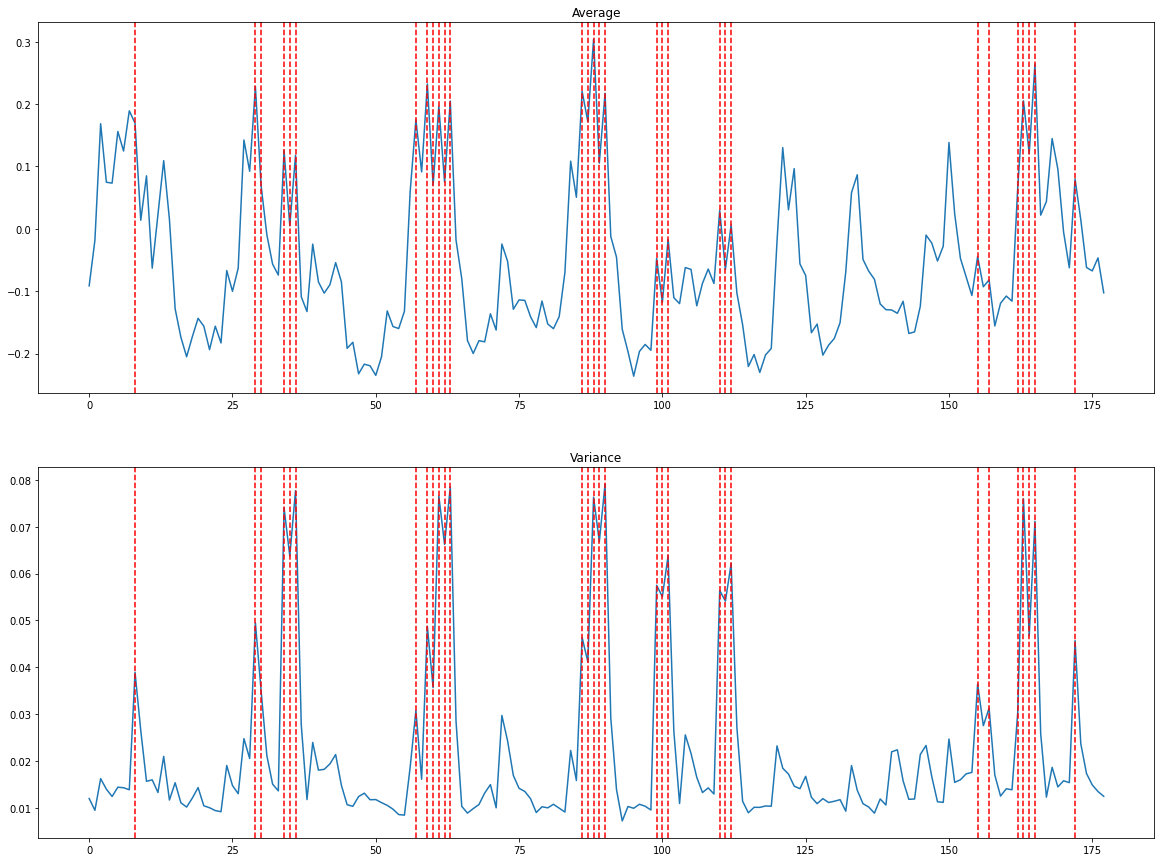

In [90]:
roiL, roiR = 1750, 1990
segL, segR = 1565+219, 1565+397
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 1)
plt.title('Average')
plt.plot(np.average(traces, axis=0)[segL:segR])
for i in var_index[:30]:
    plt.axvline(i, color='r', linestyle='--')
# plt.axvline(segL - roiL, color='r', linestyle='--')
# plt.axvline(segR - roiL, color='r', linestyle='--')
plt.subplot(2, 1, 2)
plt.title('Variance')
plt.plot(np.std(traces, axis=0, ddof=1)[segL:segR])
for i in var_index[:30]:
    plt.axvline(i, color='r', linestyle='--')
# plt.axvline(segL - roiL, color='r', linestyle='--')
# plt.axvline(segR - roiL, color='r', linestyle='--')
plt.show()

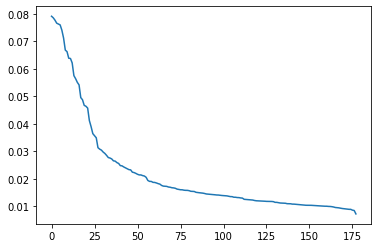

[ 90  63  36  61  88 163  34 165  89  62 101  35 112  99 110 100 111  29
  59 164  86 172  87   8 155  60  30 157  57 162  72  91  64  37 156 113
   9 102 166 104  27 150  73  39 173 146 120 141  84 140 105 145  43  31
  13  28  42  24 133  56 168 121  41  40 154 174 153 122 158  74 125 147
 106   2  58 152  11  85 170 142  10 151 171  15  32  70 175  44  25 123
 169   5  19   6 108  75 124 160   3  92 161   7 134  33  76 176  12 107
  69  48  26 109 159 177   4  47 167 126  18   0 128  77 138 144 143  50
  38 131  49  14 114 130 148 149 129  51  16 103 127 135  96  81  68  45
 139  52  20 118 119  97  46  65  94  79 136  17 116 117  21  71  80  82
  95  67  53  98   1  22 132  23  83  78 115  66 137  54  55  93]


In [69]:
sig = traces[:, segL:segR]
var = np.std(sig, ddof=1, axis=0)
var_index = np.argsort(var)[::-1]
plt.plot(var[var_index])
plt.show()
print(var_index)

In [25]:
peaks = {
    8: [61, 63, 34, 36, 88, 90, 163, 165],
    4: [99, 101, 110, 112]
}

30


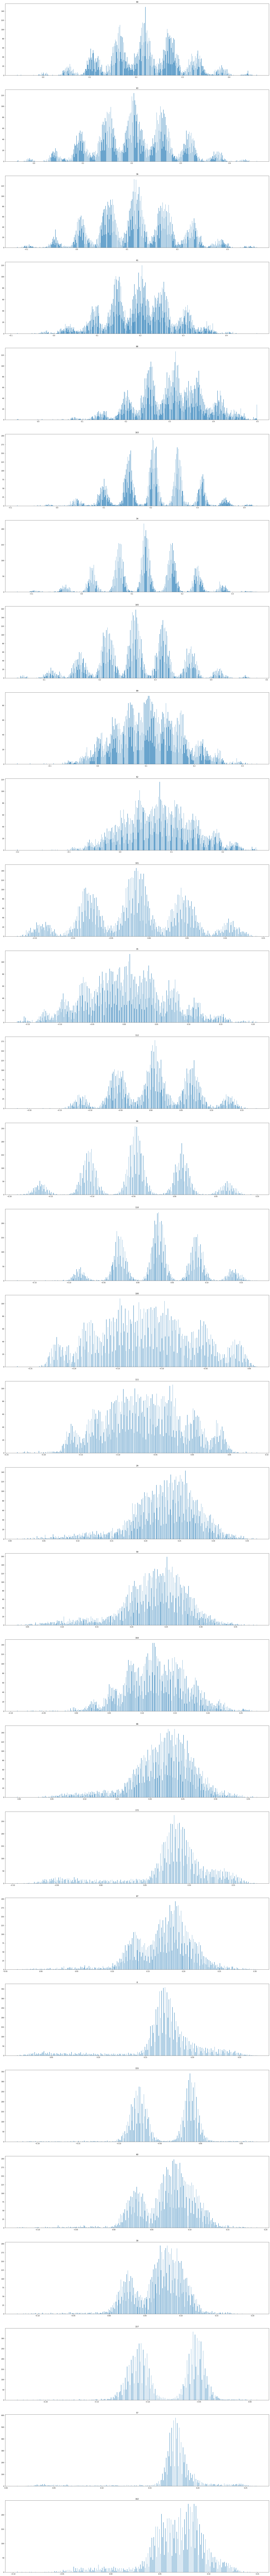

In [92]:
max_idx = len(var[var > 0.03])
print(max_idx)
plt.figure(figsize=(30,300))
for i, idx in enumerate(var_index[:max_idx]):
    plt.subplot(max_idx, 1, i+1)
    plt.hist(sig[:,idx], bins=1000)
    plt.title(idx)
plt.show()

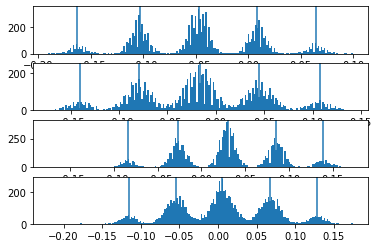

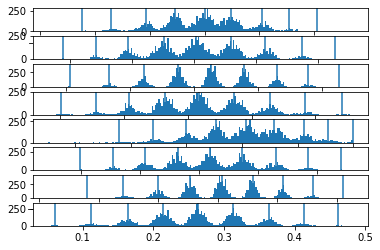

In [26]:
peaks = {
    8: [61, 63, 34, 36, 88, 90, 163, 165],
    4: [99, 101, 110, 112]
}
p = 0.5
for n in [4, 8]:
    for i, idx in  enumerate(peaks[n]):
        plt.subplot(len(peaks[n]), 1, i+1)
        plt.hist(sig[:, idx], bins=200)
        for x in [np.quantile(sig[:, idx], binom.cdf(i, n, p) - binom.pmf(i, n, p) / 2) for i in range(0, n+1)]:
            plt.axvline(x)
    plt.show()

# Quantize signal

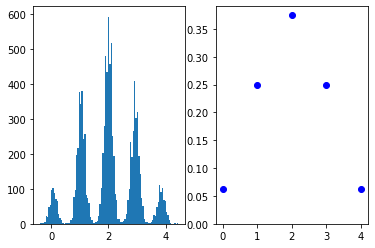

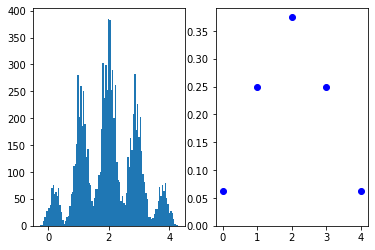

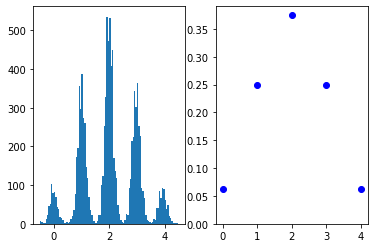

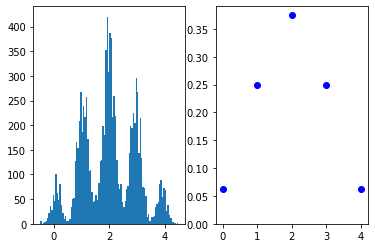

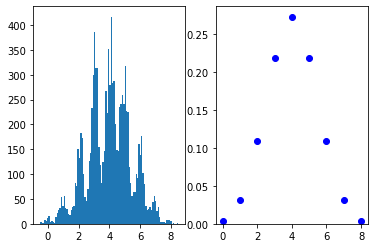

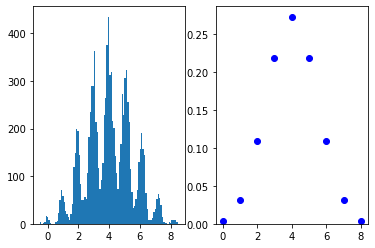

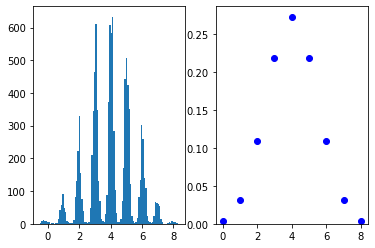

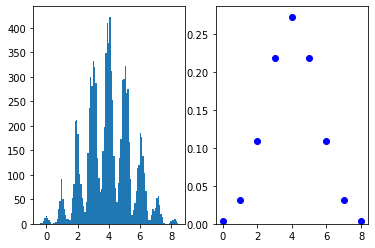

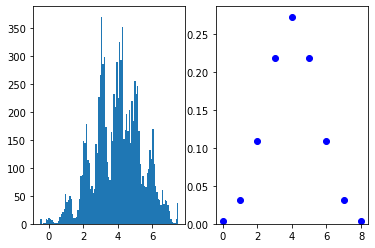

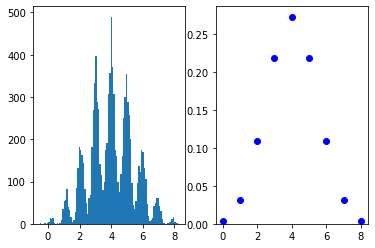

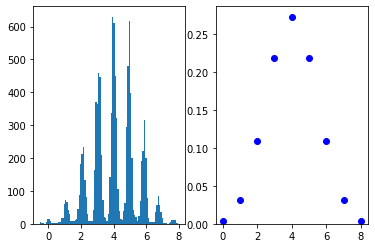

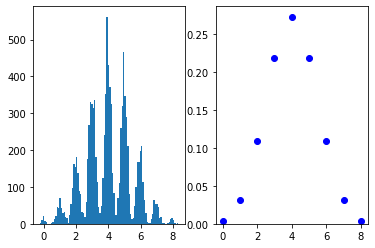

In [72]:
peaks = {
    8: [61, 63, 34, 36, 88, 90, 163, 165],
    4: [99, 101, 110, 112]
}
p = 0.5
quant_sig = dict()
normed_sig = dict()
for n in [4, 8]:
    for idx in peaks[n]:
        target = sig[:, idx]
        delta = (np.quantile(target, binom.cdf(n/2+1, n, p)) - np.quantile(target, binom.cdf(n/2-1, n, p)))/2
#         target = np.clip(np.round((target - target.mean()) / delta) + n // 2, 0, n)
        target = np.clip(((target - target.mean()) / delta) + n // 2, -0.5, n+0.5)
        normed_sig[idx] = target
        plt.subplot(1, 2, 1)
        plt.hist(target, bins=100)
        
        plt.subplot(1, 2, 2)
        plt.plot(binom.pmf(range(0, n+1), n, 0.5), 'bo',)
        plt.ylim(bottom=0)
        plt.show()
        quant_sig[idx] = np.round(target)
    

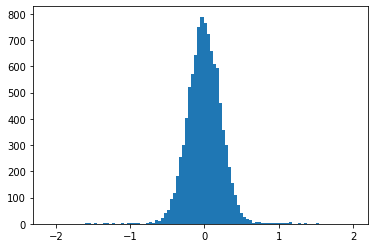

In [86]:
plt.hist(normed_sig[110] - normed_sig[112], bins=100)
plt.show()

In [73]:
quant_sig

{99: array([3., 2., 2., ..., 2., 0., 3.]),
 101: array([3., 2., 2., ..., 2., 0., 3.]),
 110: array([ 1., -0.,  3., ...,  2.,  1.,  3.]),
 112: array([1., 0., 3., ..., 2., 1., 3.]),
 61: array([5., 4., 1., ..., 3., 3., 5.]),
 63: array([5., 4., 1., ..., 3., 5., 5.]),
 34: array([4., 6., 4., ..., 3., 4., 3.]),
 36: array([4., 6., 4., ..., 3., 4., 3.]),
 88: array([3., 2., 3., ..., 6., 4., 2.]),
 90: array([3., 2., 3., ..., 6., 4., 2.]),
 163: array([2., 3., 6., ..., 6., 4., 4.]),
 165: array([5., 3., 6., ..., 6., 4., 4.])}

In [74]:
np.corrcoef(quant_sig[34], quant_sig[36])

array([[1.        , 0.98497604],
       [0.98497604, 1.        ]])

In [76]:
np.corrcoef(quant_sig[88], quant_sig[90])

array([[1.        , 0.96551578],
       [0.96551578, 1.        ]])

In [77]:
np.corrcoef(quant_sig[99], quant_sig[101])

array([[1.        , 0.98665199],
       [0.98665199, 1.        ]])

In [78]:
np.corrcoef(quant_sig[110], quant_sig[112])

array([[1.        , 0.98649008],
       [0.98649008, 1.        ]])

In [79]:
np.corrcoef(quant_sig[163], quant_sig[165])

array([[1.        , 0.97820355],
       [0.97820355, 1.        ]])

In [95]:
np.corrcoef(quant_sig[34], quant_sig[61])

array([[ 1.       , -0.0197172],
       [-0.0197172,  1.       ]])

In [100]:
np.stack([quant_sig[34], quant_sig[61], quant_sig[88], quant_sig[163]])

array([[4., 6., 4., ..., 3., 4., 3.],
       [5., 4., 1., ..., 3., 3., 5.],
       [3., 2., 3., ..., 6., 4., 2.],
       [2., 3., 6., ..., 6., 4., 4.]])

In [103]:
np.corrcoef(np.stack([quant_sig[34], quant_sig[61], quant_sig[88], quant_sig[163], quant_sig[101], quant_sig[110]]))

array([[ 1.        , -0.0197172 , -0.02205651, -0.00678626, -0.00103272,
         0.00125628],
       [-0.0197172 ,  1.        , -0.0257781 , -0.02134788, -0.01312302,
        -0.01718679],
       [-0.02205651, -0.0257781 ,  1.        ,  0.00714811, -0.01411446,
         0.01339394],
       [-0.00678626, -0.02134788,  0.00714811,  1.        ,  0.00579217,
         0.07343331],
       [-0.00103272, -0.01312302, -0.01411446,  0.00579217,  1.        ,
         0.01639951],
       [ 0.00125628, -0.01718679,  0.01339394,  0.07343331,  0.01639951,
         1.        ]])

In [106]:
import seaborn as sns; sns.set_theme()

<AxesSubplot:>

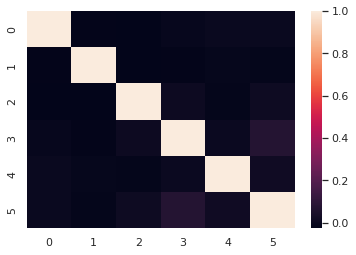

In [107]:
sns.heatmap(np.corrcoef(np.stack([quant_sig[34], quant_sig[61], quant_sig[88], quant_sig[163], quant_sig[101], quant_sig[110]])))